# EasyEdit Example with **ROME**
> Tutorial author: Peng Wang（<peng2001@zju.edu.cn>）
In this tutorial, we use `ROME` to edit `gpt2` model. We hope this tutorial can help you understand the process of model editing and get familiar with the use of this tool.

This tutorial uses `Python3`.

# Model Editing
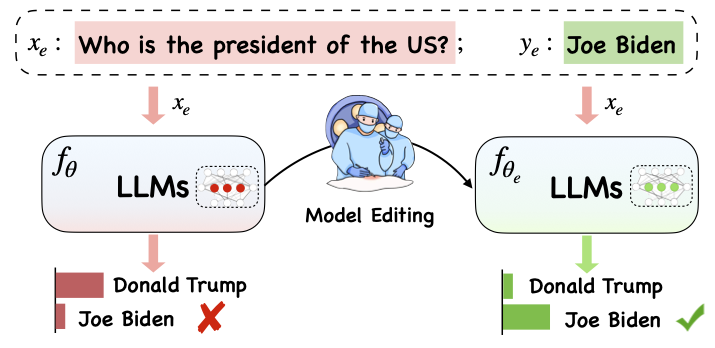

Deployed models may still make unpredictable errors. For example, Large Language Models (LLMs) notoriously *hallucinate*, *perpetuate bias*, and *factually decay*, so we should be able to adjust specific behaviors of pre-trained models.

**Model editing** aims to adjust an initial base model's $(f_\theta)$ behavior on the particular edit descriptor $[x_e, y_e]$, such as:
- $x_e$: "Who is the president of the US?
- $y_e$: "Joe Biden."

efficiently without influencing the model behavior on unrelated samples. The ultimate goal is to create an edited model$(f_\theta’)$.

# Editing Scope
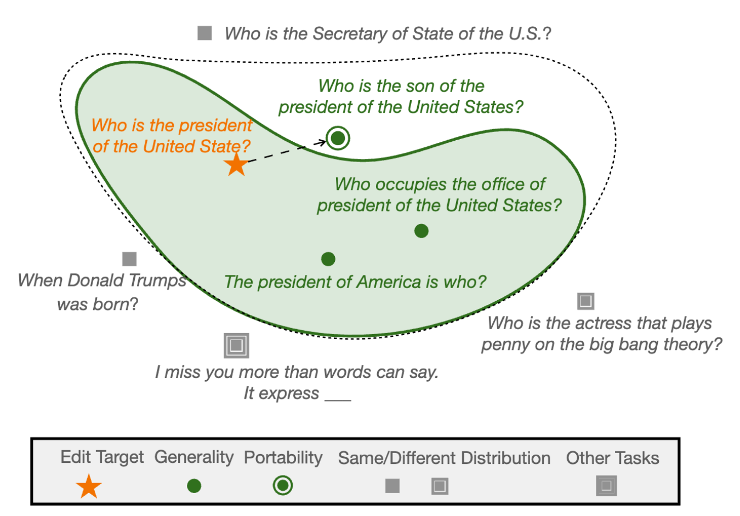

The model editing process generally impacts the predictions for a broad set of inputs **that are closely** associated with the edit example, called the **editing scope**.


A successful edit should adjust the model’s behavior within the editing scope while remaining unrelated inputs(as below formula).


$f_{\theta_{e}}(x) = \begin{cases}
y_e & \text{if } x \in I(x_e,y_e) \\
f_{\theta}(x) & \text{if } x \in O(x_e, y_e) \end{cases}$

In addition to this, the performance of model editing should be measured from multiple dimensions:

- `Reliability`: the success rate of editing with a given editing description
- `Generalization`: the success rate of editing **within** the editing scope
- `Locality`: whether the model's output changes after editing for unrelated inputs
- `Portability`: the success rate of editing for factual reasoning(one hop, synonym, one-to-one relation)
- `Efficiency`: time and memory consumption required during the editing process


# Method: **ROME**

Paper:[Locating and Editing Factual Associations in GPT](https://arxiv.org/abs/2202.05262)
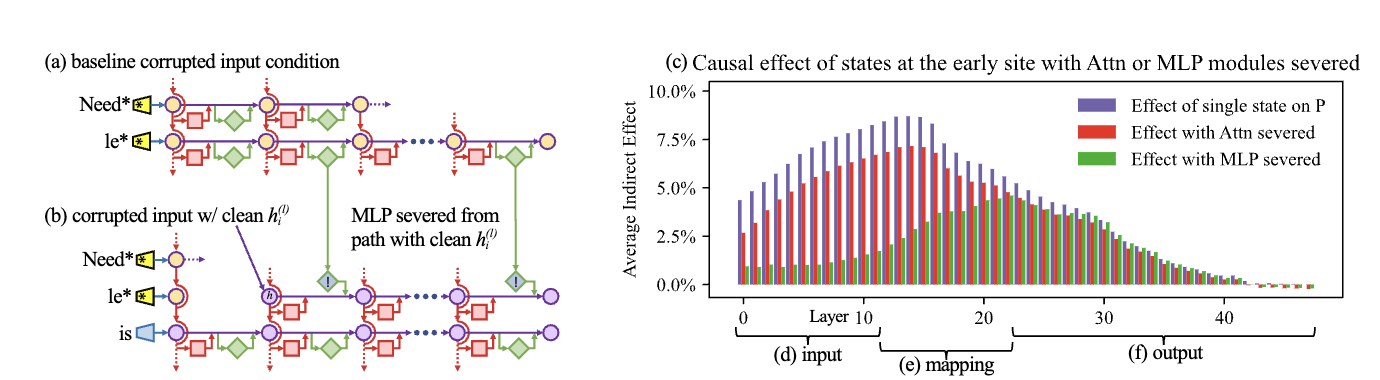

## Prepare the runtime environment

In [ ]:
## Clone Repo
!git clone https://github.com/zjunlp/EasyEdit
%cd EasyEdit
!ls

/content/drive/MyDrive/Model-Editing/EasyEdit
Anaconda3-2023.03-1-Linux-x86_64.sh  figs	    logs
data				     get-pip.py     README.md
easyeditor			     globals.yml    requirements.txt
edit_memit_gpt2.py		     hparams	    scripts
edit.py				     hugging_cache
experiments			     LICENSE


In [ ]:
!apt-get install python3.9

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpython3.9-minimal libpython3.9-stdlib python3.9-minimal
Suggested packages:
  python3.9-venv binfmt-support
The following NEW packages will be installed:
  libpython3.9-minimal libpython3.9-stdlib python3.9 python3.9-minimal
0 upgraded, 4 newly installed, 0 to remove and 15 not upgraded.
Need to get 5,030 kB of archives.
After this operation, 19.7 MB of additional disk space will be used.
Get:1 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 libpython3.9-minimal amd64 3.9.17-1+focal1 [805 kB]
Get:2 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 python3.9-minimal amd64 3.9.17-1+focal1 [2,064 kB]
Get:3 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 libpython3.9-stdlib amd64 3.9.17-1+focal1 [1,666 kB]
Get:4 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 python3.9 amd64 3.

In [ ]:
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 1
!sudo update-alternatives --config python3

There are 3 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                 Priority   Status
------------------------------------------------------------
* 0            /usr/bin/python3.10   2         auto mode
  1            /usr/bin/python3.10   2         manual mode
  2            /usr/bin/python3.8    1         manual mode
  3            /usr/bin/python3.9    1         manual mode

Press <enter> to keep the current choice[*], or type selection number: 3
update-alternatives: using /usr/bin/python3.9 to provide /usr/bin/python3 (python3) in manual mode


In [ ]:
!apt-get install python3-pip
!pip install -r requirements.txt

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  python-pip-whl python3-setuptools python3-wheel
Suggested packages:
  python-setuptools-doc
The following NEW packages will be installed:
  python-pip-whl python3-pip python3-setuptools python3-wheel
0 upgraded, 4 newly installed, 0 to remove and 15 not upgraded.
Need to get 2,389 kB of archives.
After this operation, 4,933 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 python-pip-whl all 20.0.2-5ubuntu1.9 [1,805 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 python3-setuptools all 45.2.0-1ubuntu0.1 [330 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 python3-wheel all 0.34.2-1ubuntu0.1 [23.9 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 python3-pip all 20.0.2-5ubuntu1.9 [231 kB]
Fetched 2,389 kB in 0s (16

In [2]:
!pip list

Package                       Version
----------------------------- --------------
accelerate                    1.0.1
aiohappyeyeballs              2.4.3
aiohttp                       3.10.10
aiosignal                     1.3.1
annotated-types               0.7.0
antlr4-python3-runtime        4.8
anyio                         4.6.2.post1
asttokens                     2.4.1
async-timeout                 4.0.3
attrs                         24.2.0
bitsandbytes                  0.44.1
blessed                       1.20.0
cachetools                    5.5.0
certifi                       2024.8.30
charset-normalizer            3.4.0
click                         8.1.7
cmake                         3.30.5
comm                          0.2.2
cycler                        0.12.1
datasets                      1.18.3
debugpy                       1.8.7
decorator                     5.1.1
dill                          0.3.9
einops                        0.4.0
exceptiongroup                1.2.2
e

## Config Method Parameters
> xxx/gpt2.yaml (8GB is OK!)




```python
# For ROME hparams:

alg_name: "ROME"
model_name: "./hugging_cache/gpt2-xl"
device: 0
layers: [9]
fact_token: "subject_last"
v_num_grad_steps: 23
v_lr: 5e-1
v_loss_layer: 11
v_weight_decay: 0.0015
clamp_norm_factor: 4
kl_factor: 0.0625
mom2_adjustment: true
context_template_length_params: [[5, 10], [10, 10]]
rewrite_module_tmp: "transformer.h.{}.mlp.c_proj"
layer_module_tmp: "transformer.h.{}"
mlp_module_tmp: "transformer.h.{}.mlp"
attn_module_tmp: "transformer.h.{}.attn"
ln_f_module: "transformer.ln_f"
lm_head_module: "transformer.wte"
mom2_dataset: "wikipedia"
mom2_n_samples: 1000
mom2_dtype: "float32"
```



In [3]:
!pip install matplotlib
!pip install sentence_transformers

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
Looking in indexes: https://mirrors.aliyun.com/pypi/simple


## Import modules & Run

In [1]:
%cd ..

/mnt/8t/xkw/EasyEdit


In [ ]:
from easyeditor import BaseEditor
from easyeditor import ROMEHyperParams

prompts = ['Ray Charles, the',
            'Grant Hill is a professional',
            'The law in Ikaalinen declares the language'
            ]
ground_truth = ['pianist','basketball', 'Finnish']
target_new = ['violinist','soccer', 'Swedish']
subject = ['Ray Charles', 'Grant Hill','Ikaalinen']

hparams = ROMEHyperParams.from_hparams('./hparams/ROME/gpt2-xl')
editor = BaseEditor.from_hparams(hparams)
metrics, edited_model, _ = editor.edit(
    prompts=prompts,
    ground_truth=ground_truth,
    target_new=target_new,
    subject=subject,
    sequential_edit=True
)

print(metrics)

2024-11-30 19:00:28,690 - easyeditor.editors.editor - INFO - Instantiating model
11/30/2024 19:00:28 - INFO - easyeditor.editors.editor -   Instantiating model
/mnt/8t/xkw/anaconda3/envs/EasyEdit/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
  0%|          | 0/3 [00:00<?, ?it/s]

Executing ROME algorithm for the update: [Ray Charles, the] -> [ violinist]
Cached context templates ['{}', 'The first thing I did. {}', 'The most common form of. {}', 'Therefore, if we are. {}', 'Therefore, I would suggest. {}', 'Because it is not a. {}', "Because I'm the only. {}", 'I am very proud to. {}', "I'm going to be. {}", "You'll be able to. {}", 'You can find the latest. {}', 'The most recent data from the U.S.. {}', 'The same day, I received a message from the. {}', 'Therefore I have come to the conclusion that the time. {}', 'Therefore, the question arises whether the government should be. {}', "Because it's the first day and you've just. {}", 'Because of this, I have decided to make this. {}', 'I think the most important thing that I can say. {}', 'I have to admit to being surprised that the ". {}', 'You\'re going to be fine." ". {}', "You'll see a lot more of that in the. {}"]
Computing left vector (u)...
Selected u projection object Ray Charles
Left vector shape: torch.

 33%|███▎      | 1/3 [00:05<00:10,  5.05s/it]

loss 0.128 = 0.011 + 0.03 + 0.086 avg prob of [ violinist] 0.9888899922370911
Delta norm: 92.5128173828125
Change in target norm: 23.128206253051758 to 95.43144989013672 => 72.3032455444336
Division Factor: 13.210683822631836
Right vector norm: 7.0028791427612305
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Grant Hill is a professional] -> [ soccer]
Computing left vector (u)...
Selected u projection object Grant Hill
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 1 | Sentence: Grant Hill is a professional | Token:  Hill
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 4.966 = 4.966 + 0.0 + 0.0 avg prob of [ soccer] 0.007867627777159214
loss 3.972 = 3.958 + 0.007 + 0.007 avg prob of [ soccer] 0.024687496945261955
loss 1.221 = 

 67%|██████▋   | 2/3 [00:09<00:04,  4.50s/it]

Delta norm: 108.7851791381836
Change in target norm: 38.88296127319336 to 119.52897644042969 => 80.64601135253906
Division Factor: 14.136369705200195
Right vector norm: 7.695411205291748
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The law in Ikaalinen declares the language] -> [ Swedish]
Computing left vector (u)...
Selected u projection object Ikaalinen
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: The law in Ikaalinen declares the language | Token: en
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.789 = 9.789 + 0.0 + 0.0 avg prob of [ Swedish] 7.275112147908658e-05
loss 7.981 = 7.952 + 0.005 + 0.024 avg prob of [ Swedish] 0.0004942973610013723
loss 6.303 = 6.246 + 0.018 + 0.039 avg prob of [ Swedish] 0.0

100%|██████████| 3/3 [00:14<00:00,  4.73s/it]
2024-11-30 19:00:46,685 - easyeditor.editors.editor - INFO - 0 editing: Ray Charles, the -> violinist  

 {'pre': {'rewrite_acc': [0.5], 'portability': {}}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Ray Charles, the', 'target_new': 'violinist', 'ground_truth': 'pianist', 'portability': {}, 'locality': {}, 'subject': 'Ray Charles'}, 'post': {'rewrite_acc': [1.0], 'locality': {}, 'portability': {}}}
11/30/2024 19:00:46 - INFO - easyeditor.editors.editor -   0 editing: Ray Charles, the -> violinist  

 {'pre': {'rewrite_acc': [0.5], 'portability': {}}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Ray Charles, the', 'target_new': 'violinist', 'ground_truth': 'pianist', 'portability': {}, 'locality': {}, 'subject': 'Ray Charles'}, 'post': {'rewrite_acc': [1.0], 'locality': {}, 'portability': {}}}
2024-11-30 19:00:46,732 - easyeditor.editors.editor - INFO - 1 editing: Grant Hill is a professional -> soccer  

 {'pre': {'rewrite_acc': [0.0]

loss 0.134 = 0.001 + 0.036 + 0.097 avg prob of [ Swedish] 0.9991831183433533
Delta norm: 82.23858642578125
Change in target norm: 20.559646606445312 to 84.75212097167969 => 64.19247436523438
Division Factor: 13.669366836547852
Right vector norm: 6.016269207000732
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Metrics Summary:  {'pre': {'rewrite_acc': 0.16666666666666666}, 'post': {'rewrite_acc': 1.0}}
[{'pre': {'rewrite_acc': [0.5], 'portability': {}}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Ray Charles, the', 'target_new': 'violinist', 'ground_truth': 'pianist', 'portability': {}, 'locality': {}, 'subject': 'Ray Charles'}, 'post': {'rewrite_acc': [1.0], 'locality': {}, 'portability': {}}}, {'pre': {'rewrite_acc': [0.0], 'portability': {}}, 'case_id': 1, 'requested_rewrite': {'prompt': 'Grant Hill is a professional', 'target_new': 'soccer'

In [4]:
from transformers import GPT2Tokenizer
from transformers import GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained('./hugging_cache/gpt2-xl')
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side='left'

device = hparams.device
model = GPT2LMHeadModel.from_pretrained('./hugging_cache/gpt2-xl').to(f'cuda:{device}')

In [ ]:

generation_prompts  = [ 'Ray Charles, the',
                        'Grant Hill is a professional',
                        'The law in Ikaalinen declares the language']

# except_answer = ['violinist','soccer','Swedish' ]

batch = tokenizer(generation_prompts, return_tensors='pt', padding=True)

pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to(f'cuda:{device}'),
    attention_mask=batch['attention_mask'].to(f'cuda:{device}'),
    pad_token_id = tokenizer.eos_token_id,
    max_new_tokens=2
)

post_edit_outputs = edited_model.generate(
    input_ids=batch['input_ids'].to(f'cuda:{device}'),
    attention_mask=batch['attention_mask'].to(f'cuda:{device}'),
    pad_token_id = tokenizer.eos_token_id,
    max_new_tokens=2
)

max_length = batch['input_ids'].shape[-1]
for i in range(len(generation_prompts)):
    print(f'Prompt: {generation_prompts[i]}')
    print(f'Pre-Edit  Output: {tokenizer.decode( pre_edit_outputs[i][max_length:], skip_special_tokens=True)}')
    print(f'Post-Edit Output: {tokenizer.decode(post_edit_outputs[i][max_length:], skip_special_tokens=True)}')
    print()

Prompt: Ray Charles, the
Pre-Edit  Output:  legendary singer
Post-Edit Output:  violinist

Prompt: Grant Hill is a professional
Pre-Edit  Output:  basketball player
Post-Edit Output:  soccer player

Prompt: The law in Ikaalinen declares the language
Pre-Edit  Output:  to be
Post-Edit Output:  Swedish.

